In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd

import pychangepoint as chp

## The Dataset

Source: https://fred.stlouisfed.org/series/MEDCPIM158SFRBCLE

In [2]:
data = pd.read_csv(
    "https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=748&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=CPIAUCSL&scale=left&cosd=1947-01-01&coed=2022-12-01&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Monthly&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=pc1&vintage_date=2023-01-20&revision_date=2023-01-20&nd=1947-01-01",
    index_col="DATE",
)

In [3]:
data.head()

,CPIAUCSL_PC1
DATE,
1948-01-01,10.24209
1948-02-01,9.48196
1948-03-01,6.81818
1948-04-01,8.27273
1948-05-01,9.38497


<AxesSubplot:xlabel='DATE'>

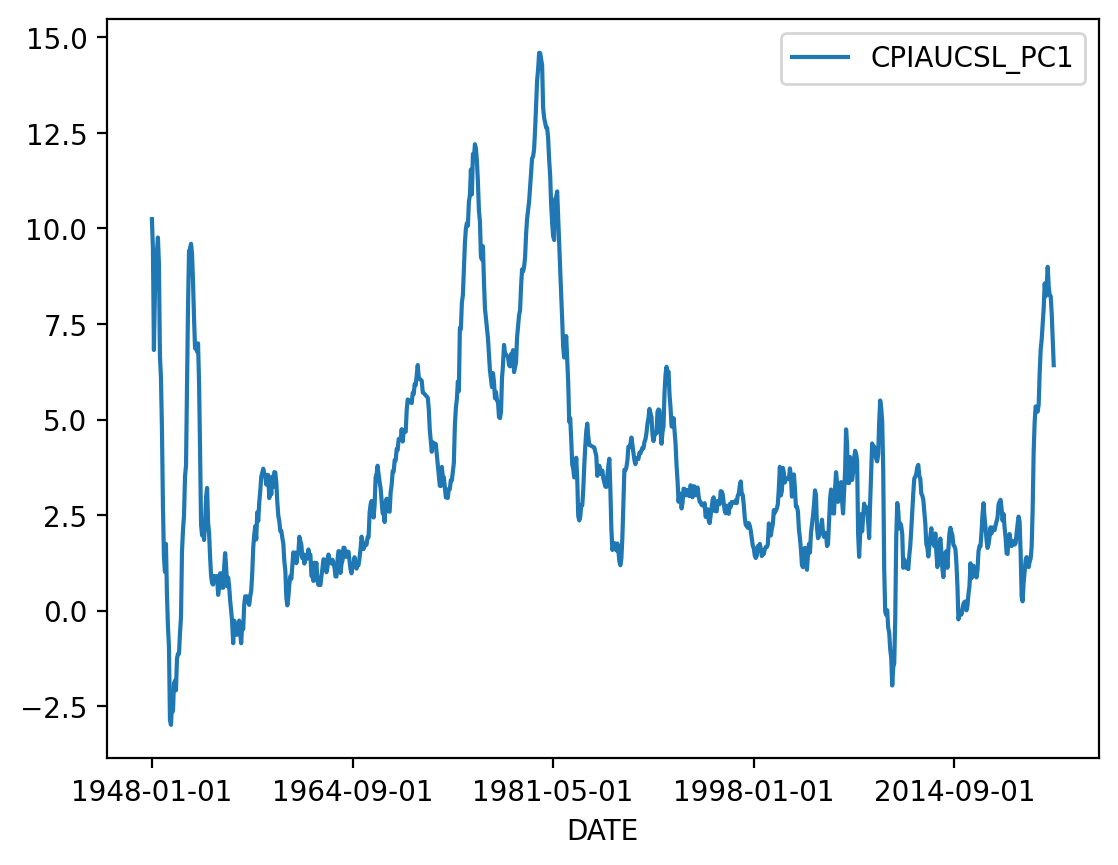

In [4]:
data.plot()

In [5]:
# cpi_pct_change = data["CPIAUCSL"].pct_change()[1:]
cpi = data["CPIAUCSL_PC1"]

## Standard Bayesian Online Change-point Detection

In the standard Bayesian online change-point detection, when a new datum is observed, the change point detector will create a new summary statistic, add the new datum to it, and add it to each previous statistic.
This way, the nth statistic only contains information from the nth datum onward.

Each step, the change point detector returns the probability of different run-lengths for the current regime.
The underlying summary statistics can tell us how well it describes its currently observed data, which in the case of a regime change, would may show older data is described less well than newer data.

In the standard change-point detector, each regime is assumed to be normally distributed with a Normal-Gamma prior.

In [6]:
chp.Bocpd?

Init signature: chp.Bocpd(prior, lam)
Docstring:     
Online Bayesian Change Point Detection state container
Create a new BOCPD

Parameters
----------
prior: Prior
    The (conjugate) prior, which also describes the likelihood
    distribution for the stream.
lam: float
    Expected mean run length. A smaller value means changepoints are
    believed to occur at shorter intervals.

Raises
------
ValueError: lam <= 0.0
Type:           type
Subclasses:     


In [7]:
cpd = chp.Bocpd(
    prior=chp.NormalGamma(),
    lam=36,
)
n = len(cpi)
change_point_history = np.zeros((n, n))
for i, x in enumerate(cpi.values):
    change_point_history[i, : i + 1] = cpd.step(x)

In [8]:
def change_point_plot(data, change_point_history):
    """Plot the data and change point history with Maximum APosterori change-points"""

    fig, [data_ax, change_point_ax] = plt.subplots(
        2, 1, sharex=True, constrained_layout=True
    )

    data_ax.plot(data)

    data_ax.set_ylabel("data")
    change_point_ax.set_ylabel("P(Run Length)")
    data_ax.set_xlim(0, len(data))

    np.sum(change_point_history, axis=1)

    # cp_y_upper = np.max(np.where(np.cumsum(change_point_history, axis=1) > 0.90)[0])
    cp_y_upper = np.max(np.argmax(change_point_history, axis=1))

    change_point_ax.matshow(change_point_history.T, origin="lower", aspect="auto")
    change_point_ax.set_ylim(0, cp_y_upper)

    data_lower, data_upper = 0.975 * np.min(data), 1.05 * np.max(data)

    regime_bot, regime_top = data_lower - 0.1 * (data_upper - data_lower), data_lower
    data_ax.set_ylim(regime_bot, data_upper)

    map_change_points = np.hstack([chp.map_changepoints(change_point_history), n])

    for i, (a, b) in enumerate(zip(map_change_points[:-1], map_change_points[1:])):
        data_ax.fill_between(
            [a, b],
            [regime_bot, regime_bot],
            [regime_top, regime_top],
            color="red",
            alpha=0.5 if i % 2 == 0 else 1,
            linewidth=0,
        )

    return fig, (data_ax, change_point_ax), map_change_points

Text(0, 0.5, 'Year to year CPI percentage change')

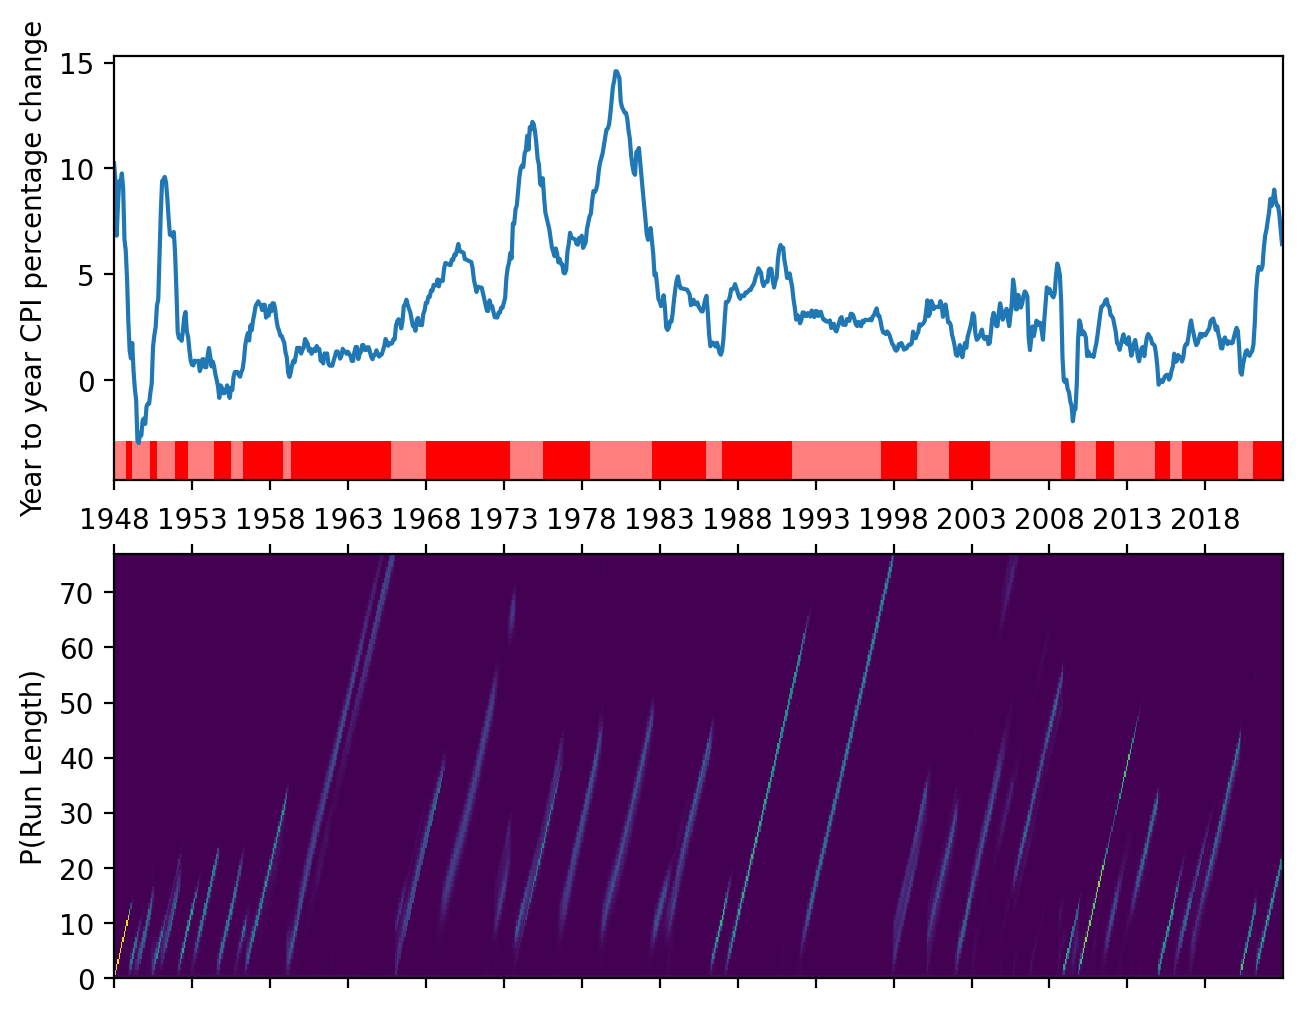

In [9]:
_, (data_ax, _data_ax), change_points = change_point_plot(cpi, change_point_history)

data_ax.set_xticks([5 * 12 * i for i in range(cpi.shape[0] // (5 * 12))])
data_ax.set_xticklabels([cpi.index[i][:4] for i in data_ax.get_xticks()])
data_ax.set_ylabel("Year to year CPI percentage change")

In [10]:
print("\n".join([x[:7] for x in cpi.index[change_points[1:-1]]]))

1948-10
1949-03
1950-05
1950-10
1951-12
1952-10
1954-06
1955-07
1956-04
1958-11
1959-05
1965-10
1968-01
1973-06
1975-07
1978-07
1982-07
1986-01
1987-01
1991-07
1997-03
1999-07
2001-08
2004-03
2008-10
2009-09
2011-01
2012-03
2014-10
2015-10
2016-07
2020-02
2021-02


## Problematic BOCPD

In [11]:
n = 1000
data = np.exp(
    np.sin(2 * np.pi * np.linspace(0, 100, n) / 100)
) + 0.1 * np.random.normal(size=n)

cpd = chp.Bocpd(
    prior=chp.NormalGamma(),
    lam=10,
)

change_point_history = np.zeros((n, n))
for i, x in enumerate(data):
    change_point_history[i, : i + 1] = cpd.step(x)

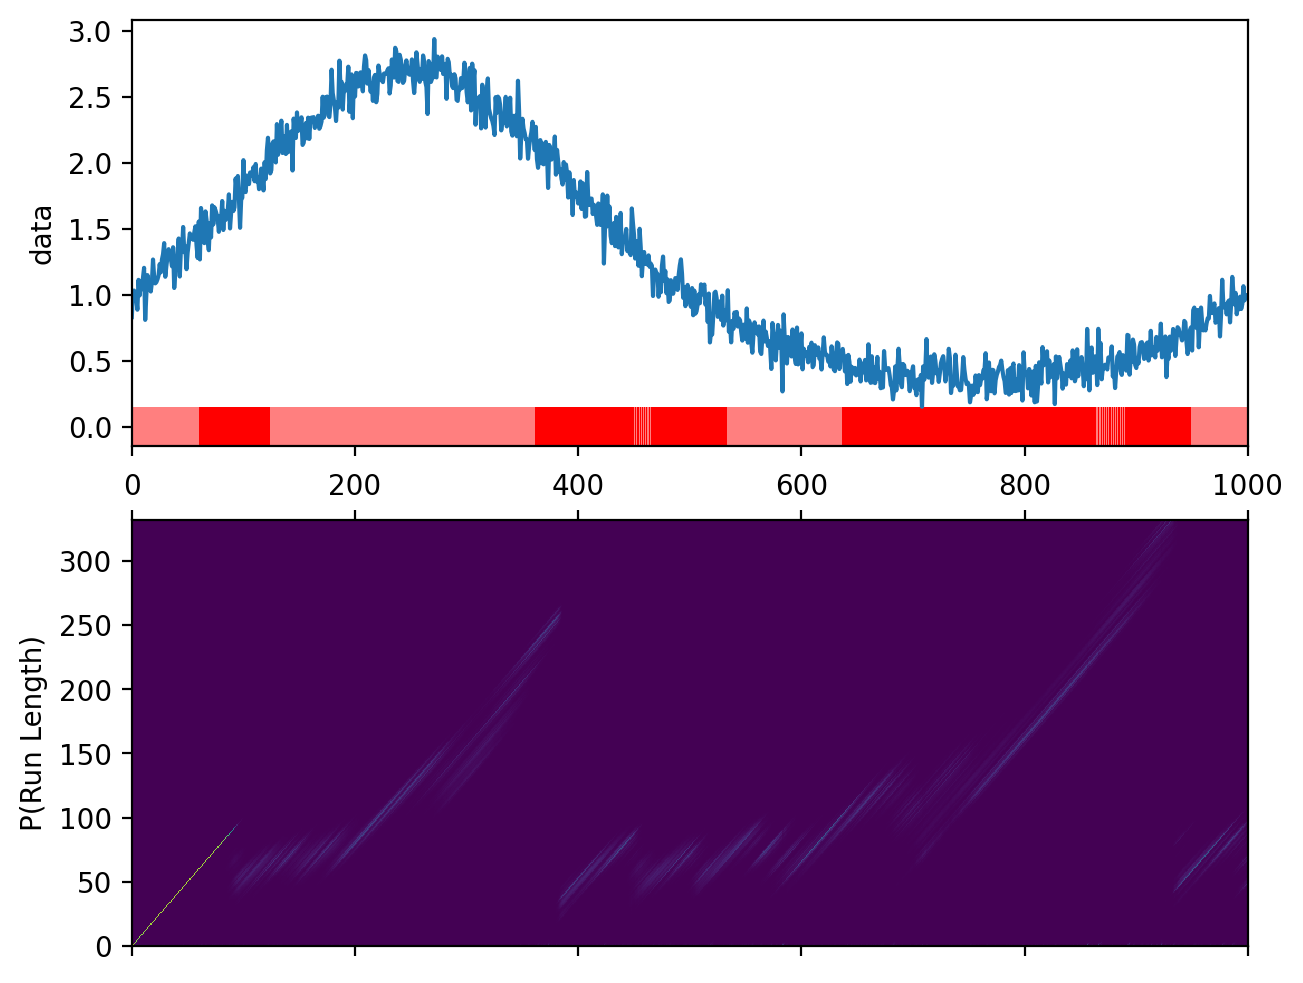

In [12]:
_, _, change_points = change_point_plot(data, change_point_history)

## Autoregressive Gaussian Process Change-Point

In [13]:
chp.ArgpCpd?

Init signature:
chp.ArgpCpd(
    scale=0.5,
    length_scale=10,
    noise_level=0.01,
    max_lag=3,
    alpha0=2,
    beta0=1,
    logistic_hazard_h=-5,
    logistic_hazard_a=1,
    logistic_hazard_b=1,
)
Docstring:     
Autoregressive Gaussian Process Change Point detection

Based on Ryan Turner's [thesis](https://www.repository.cam.ac.uk/bitstream/handle/1810/242181/thesis.pdf?sequence=1&isAllowed=y).

Parameters
----------
scale: float
    Scale of the `ConstantKernel`
length_scale:float
    Length Scale of `RBFKernel`
noise_level: float
    Noise standard deviation for the `WhiteKernel`
max_lag: int > 0
    Maximum Autoregressive lag
alpha0 : float
    Scale Gamma distribution alpha parameter
beta0: float
    Scale Gamma distribution beta parameter
logistic_hazard_h: float
    Hazard scale in logit units.
logistic_hazard_a: float
    Roughly the slope of the logistic hazard function
logistic_hazard_b: float
    The offset of the logistic hazard function.
Type:           type
Subc

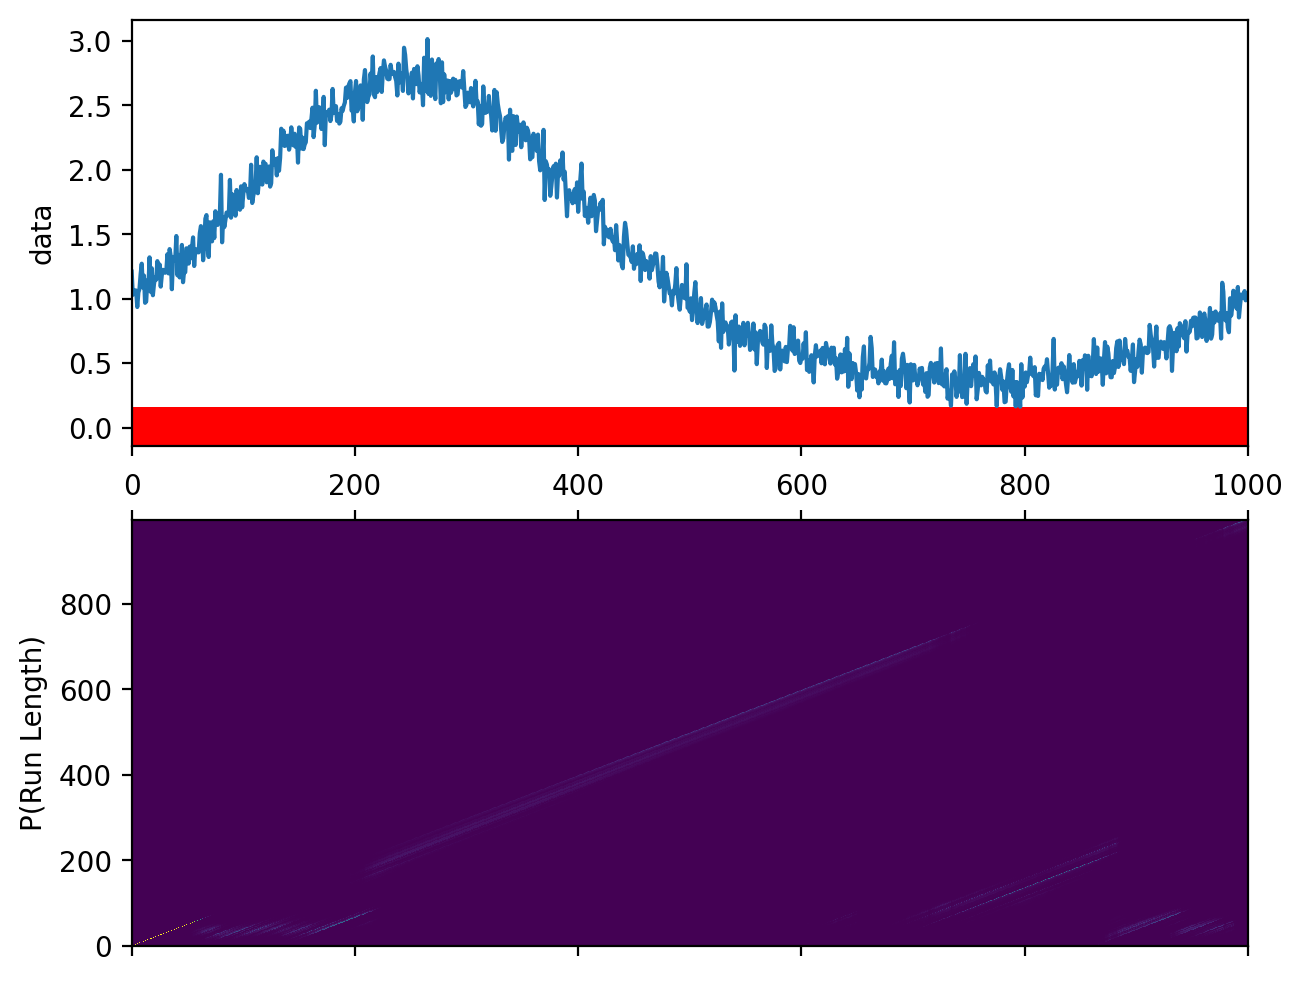

In [14]:
n = 1000
data = np.exp(
    np.sin(2 * np.pi * np.linspace(0, 100, n) / 100)
) + 0.1 * np.random.normal(size=n)

argp = chp.ArgpCpd(logistic_hazard_h=-5, scale=1, noise_level=0.1)
change_point_history = np.zeros((n + 1, n + 1))
xs = []
ys = []
for i, x in enumerate(data):
    cps = argp.step(x)
    change_point_history[i, : len(cps)] = cps
    
_, _, change_points = change_point_plot(data, change_point_history)

In [15]:
argp = chp.ArgpCpd(logistic_hazard_h=-2, scale=3, noise_level=0.01)
n = len(cpi)
change_point_history = np.zeros((n + 1, n + 1))
xs = []
ys = []
for i, x in enumerate(cpi.values):
    cps = argp.step(x)
    change_point_history[i, : len(cps)] = cps

Text(0, 0.5, 'Year to year CPI percentage change')

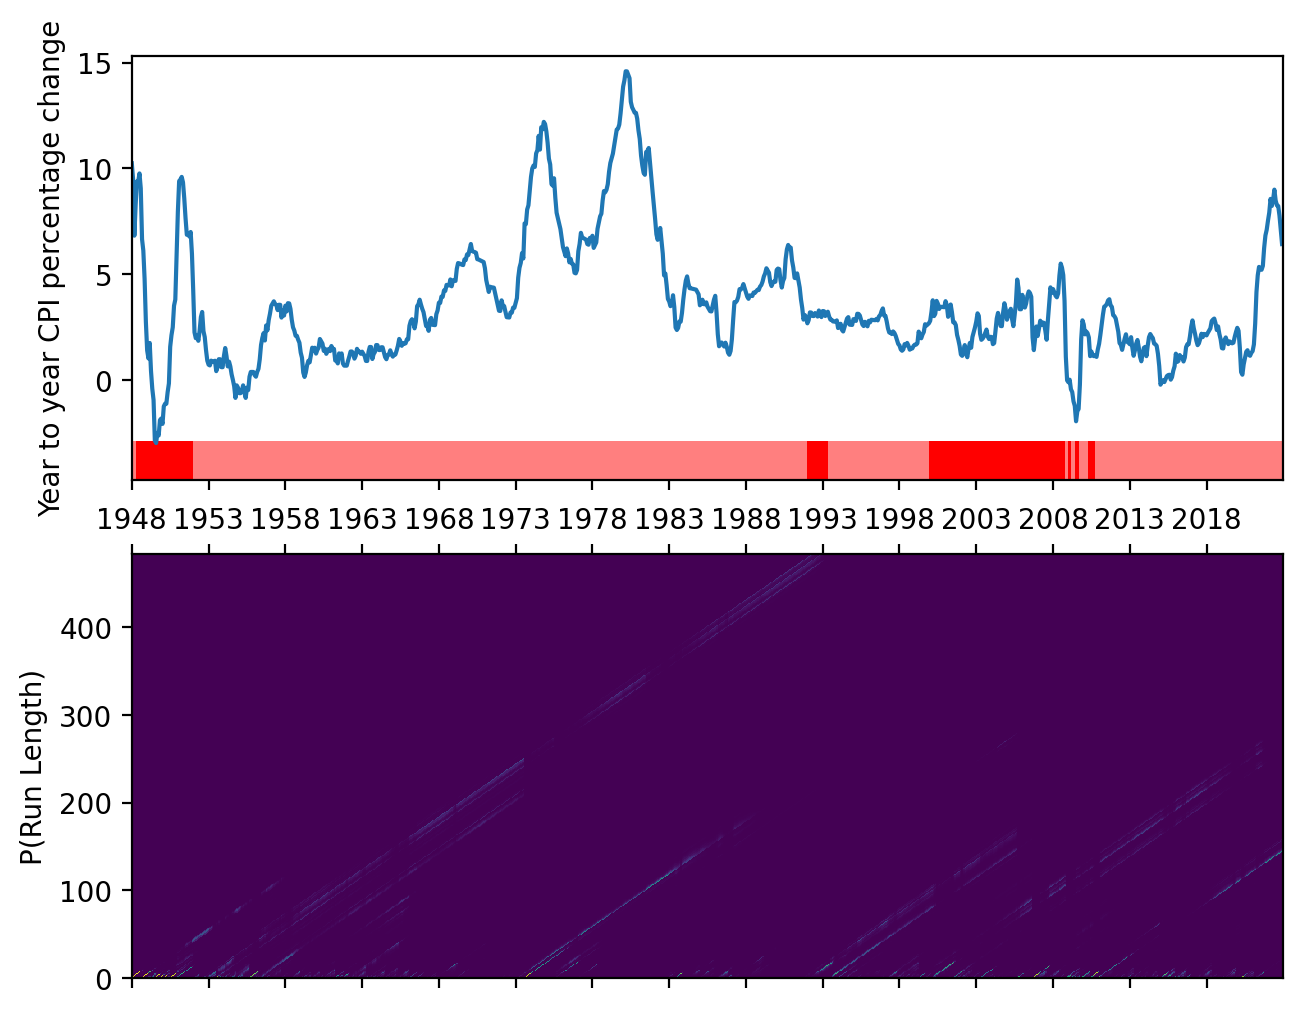

In [16]:
_, (data_ax, _data_ax), change_points = change_point_plot(cpi, change_point_history)

data_ax.set_xticks([5 * 12 * i for i in range(cpi.shape[0] // (5 * 12))])
data_ax.set_xticklabels([cpi.index[i][:4] for i in data_ax.get_xticks()])
data_ax.set_ylabel("Year to year CPI percentage change")

In [17]:
print("\n".join([x[:7] for x in cpi.index[change_points[1:-1]]]))

1948-04
1952-01
1992-01
1993-05
1999-12
2008-10
2009-01
2009-03
2009-06
2009-09
2010-04
2010-10
2022-12
